In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load data

In [324]:
df = pd.read_csv("data\ICS\Concrete_Data_2.csv", ";")
df.dtypes

1.00    float64
2.00    float64
3.00    float64
4.00    float64
5.00    float64
6.00    float64
7.00    float64
8.00    float64
9.00    float64
dtype: object

In [5]:
# Split according to distribution

df = pd.read_csv("data\ICS\Concrete_Data_2.csv", ";")
df= df.fillna(0)

# Calculate Correlation between coloumns 
corr_values = []
highest_corr = 0
highest_col = 0

for col in df:
    corr = df["9.00"].corr(df[col])
    corr_values.append(corr)
    if corr >= max(corr_values) and corr < 1.0:
        highest_corr = corr
        highest_col = col
    #print("Correlation between the target and "+ str(col) + " : " + str(corr))
    #print(highest_corr)

# Selecto Corr >= 0,4 and sort data accordingly 
print ("Column: "+str(highest_col)+ " has the highest correlation with the target: " + str(highest_corr))
df = df.sort_values(by=[highest_col])
df = df.reset_index(drop=True)

# Split df in 3 equal parts
split = int(len(df[:1000])/3)
df_1 = df.loc[0:split,:]
df_2 = df.loc[split:split*2,:]
df_3 = df.loc[split*2:split*3,:]
print("Df has been split into 3 equal parts: ",df_1.shape,df_2.shape,df_3.shape)

Column: 1.00 has the highest correlation with the target: 0.49783558206163886
Df has been split into 3 equal parts:  (334, 9) (334, 9) (334, 9)


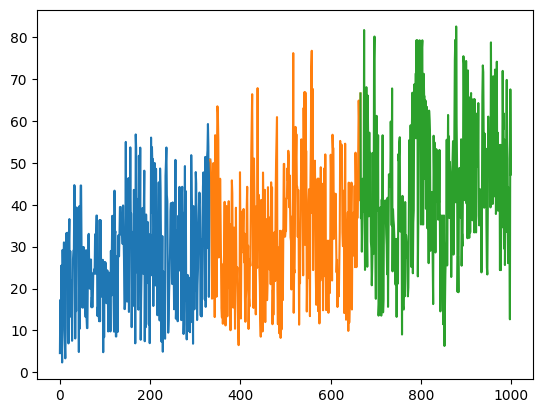

In [323]:
plt.plot(df_1["9.00"])
plt.plot(df_2["9.00"])
plt.plot(df_3["9.00"])
#plt.xlim(0, len(Xt[:25]))
plt.show()

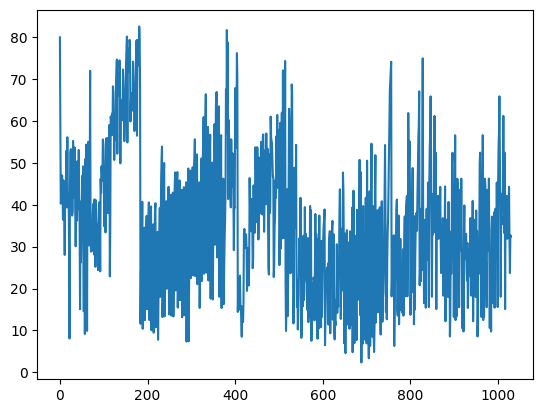

In [325]:
plt.plot(df["9.00"])
#plt.xlim(0, len(Xt[:25]))
plt.show()

## Prepare Experiment

In [6]:
df_src = df_3 #.append(df_2)
#print(df_src.head(), df_src.shape)

df_tar = df_1
#print(df_tar.head(), df_tar.shape)

In [ ]:
'''df = pd.read_csv("Concrete_Data_2.csv", ";")

df = df.astype('float32')

pd.options.display.float_format = '{:,.2f}'.format
df.apply(lambda x: x.astype(int) if np.allclose(x, x.astype(int)) else x)
df = df.drop(columns="6.00")

df_src = df.loc[0:600,:]
#print(df_src.head(), df_src.shape)

df_tar = df.loc[601:1000,:]
#print(df_tar.head(), df_tar.shape)'''

In [7]:
# source
Xs = df_src.iloc[:,:-1]
Ys = df_src.iloc[:,-1]

# target_train
Xt = df_tar.iloc[:,:-1]
Yt = df_tar.iloc[:,-1]

## Metrics

In [268]:
df_src = df_1 #.append(df_2)
#print(df_src.head(), df_src.shape)

df_tar = df_3
#print(df_tar.head(), df_tar.shape)
# source
Xs = df_src.iloc[:,:-1]
Ys = df_src.iloc[:,-1]

# target_train
Xt = df_tar.iloc[:,:-1]
Yt = df_tar.iloc[:,-1]

In [179]:
def mmd_linear(Sx, Sy, Tx, Ty):
            XX = np.dot(Sx, Tx)
            YY = np.dot(Sy, Ty)
            XY = np.dot(Sx, Ty)
            return XX.mean() + YY.mean() - 2 * XY.mean()

In [276]:
import torch
def guassian_kernel(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    n_samples = int(source.size)+int(target.size)
    total = torch.cat([source, target], dim=0)
    total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
    total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
    L2_distance = ((total0-total1)**2).sum(2)
    if fix_sigma:
        bandwidth = fix_sigma
    else:
        bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
    bandwidth /= kernel_mul ** (kernel_num // 2)
    bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
    kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
    return sum(kernel_val)#/len(kernel_val)
    
def mmd_rbf_accelerate(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    batch_size = int(source.size)
    kernels = guassian_kernel(source, target,
        kernel_mul=kernel_mul, kernel_num=kernel_num, fix_sigma=fix_sigma)
    loss = 0
    for i in range(batch_size):
        s1, s2 = i, (i+1)%batch_size
        t1, t2 = s1+batch_size, s2+batch_size
        loss += kernels[s1, s2] + kernels[t1, t2]
        loss -= kernels[s1, t2] + kernels[s2, t1]
    return loss / float(batch_size)

def mmd_rbf_noaccelerate(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    batch_size = int(source.size)
    kernels = guassian_kernel(source, target,
                              kernel_mul=kernel_mul, kernel_num=kernel_num, fix_sigma=fix_sigma)
    XX = kernels[:batch_size, :batch_size]
    YY = kernels[batch_size:, batch_size:]
    XY = kernels[:batch_size, batch_size:]
    YX = kernels[batch_size:, :batch_size]
    loss = torch.mean(XX + YY - XY -YX)
    return loss

In [273]:
Xs.size

2672

In [277]:
mmd_rbf_accelerate(Xs,Xt)

TypeError: expected Tensor as element 0 in argument 0, but got DataFrame

In [257]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def MMD(Xs, Ys, Xt, Yt, kernel):
    """Emprical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    xx, yy, zz = torch.mm(Xs, Ys), torch.mm(Xt, Yt), torch.mm(Xs, Yt)
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
    
    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)
    
    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))
    
    if kernel == "multiscale":
        
        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1
            
    if kernel == "rbf":
      
        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)
      
      

    return torch.mean(XX + YY - 2. * XY)

In [262]:
import pandas as pd
import torch

# determine the supported device
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device
# convert a df to tensor to be used in pytorch

def df_to_tensor(df):
    device = get_device()
    return torch.from_numpy(df.values).float().to(device)

#Xs = df_to_tensor(Xs)
Ys = df_to_tensor(Ys)
#Xt = df_to_tensor(Xt)
Yt = df_to_tensor(Yt)

#MMD(Xs,Ys,Xt,Yt, kernel="multiscale")

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'values'

In [316]:
df_src = df_2 #.append(df_2)
#print(df_src.head(), df_src.shape)

df_tar = df_3
#print(df_tar.head(), df_tar.shape)
# source
Xs = df_src.iloc[:,:-1]
Ys = df_src.iloc[:,-1]

# target_train
Xt = df_tar.iloc[:,:-1]
Yt = df_tar.iloc[:,-1]

In [321]:
# kann eine Metrik verwendet werden um die Gleichheit der Regressions DF abzubinden ?

from tllib.ranking import negative_conditional_entropy as nce
from tllib.ranking import log_expected_empirical_prediction as leep

from sklearn.metrics.pairwise import paired_cosine_distances
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import haversine_distances
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import paired_cosine_distances
from scipy.stats import wasserstein_distance
from scipy.stats import ks_2samp
from scipy.spatial import distance
from scipy.stats import entropy
from scipy.special import kl_div

from sklearn.metrics import mean_absolute_percentage_error


save_values = []

#Kullback-Leibler Divergenz
kull = []
interator = int (len(df_src)/len(df_tar[:25]))
c=0 

for i in range (1, interator+1):
    #print ("I=",i)
    #print (len(df_src[c:i*25]))
    kull.append(kl_div(df_src[c:i*25],df_tar[:25]).mean())
    c=i*25

kld = np.ma.masked_invalid(kull).mean()
save_values.append(kld)
    
# Cosine Distances
cosine = []
interator = int (len(df_src)/len(df_tar[:25]))
c=0 

for i in range (1, interator+1):
    #print ("I=",i)
    #print (len(df_src[c:i*25]))
    cosine.append(paired_cosine_distances(df_src[c:i*25],df_tar[:25]).mean())
    c=i*25

cd = np.mean(cosine)
save_values.append(cd)


# Wasserstein Distance
was = wasserstein_distance(Ys,Yt[:25])
save_values.append(was)

# Ad-Distance
ad = ks_2samp(Ys,Yt[:25])[0]
save_values.append(ad)

# Jensen Shannon
js = distance.jensenshannon(df_src,df_tar).mean()
save_values.append(js)

# Correlation
cor = df_tar[:25].corrwith(Ys).mean()
save_values.append(cor)

'''# MMD
mmd = []
interator = int (len(df_src)/len(df_tar[:25]))
c=0 

for i in range (1, interator+1):
    #print ("I=",i)
    #print (len(df_src[c:i*25]))
    mmd.append(mmd_linear(df_src[c:i*25],df_src[c:i*25],Xt[:25],Yt[:25]))
    c=i*25'''

mmd = 1 #np.mean(mmd) 
save_values.append(mmd)

In [322]:
save_values

[12.965779522115675,
 0.017314818364388185,
 10.945356886227543,
 0.3438323353293413,
 0.30113347471802354,
 nan,
 1]

In [226]:
save_values

[1,
 0.02328045808367788,
 17.27619520958084,
 0.5055089820359281,
 0.29978701968551635,
 nan,
 1]

# Models


## BDA

In [ ]:
from TL_Regression_Methods.BDA import BDA

bda = BDA(kernel_type='primal', dim=30, lamb=1, mu=0.5, mode='BDA', gamma=1, estimate_mu=False)
mse_bda, y_pre_bda, list_acc = bda.fit_predict(Xs, Ys, Xt[:25], Yt[:25])
print(f'The MSE of BDA is: {mse_bda:.4f}')

plt.plot(Yt.reset_index(drop=True))
plt.plot(y_pre_bda)
plt.xlim(0, 25)
plt.title('BDA with MSE: '+ str(mse_bda))
plt.xlabel('Sampels')
plt.ylabel('Strength')
plt.show()

# ISt so implementiert das es so viele Durchläufe gibt wie Klassen 

## JDA

The accuracy of JDA is: 3871.0134


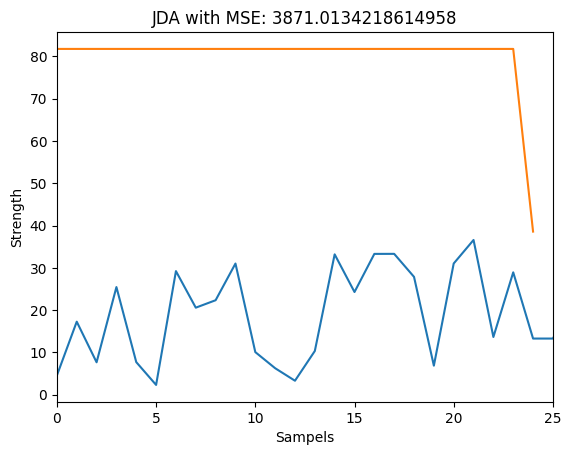

In [9]:
#from TL_Regression_Methods.JDA import JDA

jda = JDA(kernel_type='primal', dim=30, lamb=1, gamma=1)
mse_jda, y_pre_jda, list_acc = jda.fit_predict(Xs, Ys, Xt[:25], Yt[:25])
print(f'The accuracy of JDA is: {mse_jda:.4f}')

plt.plot(Yt.reset_index(drop=True))
plt.plot(y_pre_jda)
plt.xlim(0, 25)
plt.title('JDA with MSE: '+ str(mse_jda))
plt.xlabel('Sampels')
plt.ylabel('Strength')
plt.show()

## Coral

The MSE of Coral is: 190.9849


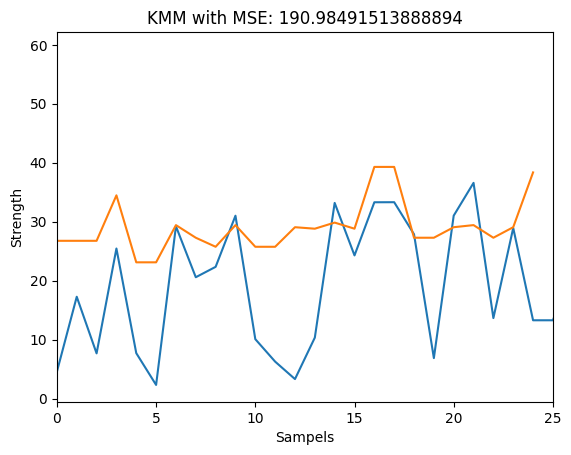

In [37]:
from TL_Regression_Methods.CORAL import CORAL

coral = CORAL()
k = 12
mse_coral, y_pre_coral = coral.fit_predict(Xs, Ys, Xt[:25], Yt[:25], k)
print(f'The MSE of Coral is: {mse_coral:.4f}')

plt.plot(Yt.reset_index(drop=True))
plt.plot(y_pre_coral)
plt.xlim(0, 25)
plt.title('KMM with MSE: '+ str(mse_coral))
plt.xlabel('Sampels')
plt.ylabel('Strength')
plt.show()

## KMM

In [146]:
from TL_Regression_Methods.KMM import KMM
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

results_transfer = []
results_transfer_val = []

model = KNeighborsRegressor(n_neighbors=3) #linear_model.Lasso(alpha=15) #DecisionTreeRegressor(max_depth=5)
model.fit(Xs, Ys)
y_pre_kmm = model.predict(Xt[:25])
mse_kmm = mean_squared_error(Yt[:25], y_pre_kmm)

results_transfer.append(mse_kmm)
y_pre_ridge = model.predict(Xt[25:])
mse_kmm_val = sklearn.metrics.mean_squared_error(Yt[25:], y_pre_ridge)
results_transfer_val.append(mse_kmm_val)

'''plt.plot(Yt.reset_index(drop=True))
plt.plot(y_pre_kmm)
plt.xlim(0, len(Xt[:25]))
plt.title('KMM with MSE: '+ str(mse_kmm))
plt.xlabel('Sampels')
plt.ylabel('Strength')
plt.show()'''

print("MSE Transfer Testdata: ", np.mean(results_transfer))
print("MSE Transfer Validationdata: ", np.mean(results_transfer_val))

MSE Transfer Testdata:  961.2565431111111
MSE Transfer Validationdata:  388.01193160733544


## LWE

pur  0.014970059880239521
SVR(kernel='linear')
SVR(C=1, gamma=2)


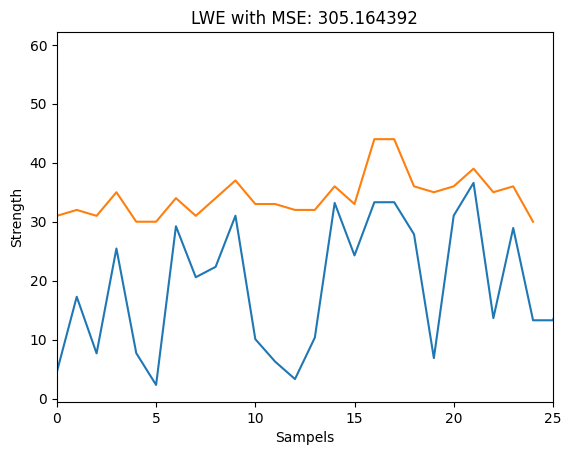

In [16]:
import sklearn
from TL_Regression_Methods.LWE import LWE

model = LWE()
y_pre_lwe = model.fit_predict(Xs, Ys, Xt[:25])
mse_lwe = sklearn.metrics.mean_squared_error(Yt[:25], y_pre_lwe)

plt.plot(Yt.reset_index(drop=True))
plt.plot(y_pre_lwe)
plt.xlim(0, 25)
plt.title('LWE with MSE: '+ str(mse_lwe))
plt.xlabel('Sampels')
plt.ylabel('Strength')
plt.show()

In [137]:
df_src = df_1 #.append(df_2)
#print(df_src.head(), df_src.shape)

df_tar = df_3
#print(df_tar.head(), df_tar.shape)
# source
Xs = df_src.iloc[:,:-1]
Ys = df_src.iloc[:,-1]

# target_train
Xt = df_tar.iloc[:,:-1]
Yt = df_tar.iloc[:,-1]

## TwoStageTrAdaBoostR2

334 18 7
At step: 3
Binary search's goal not meeted! Value is set to be the available best!
Try reducing the search interval. Current stp interval: 1e-30
At step: 4
Binary search's goal not meeted! Value is set to be the available best!
Try reducing the search interval. Current stp interval: 1e-30
At step: 5
Binary search's goal not meeted! Value is set to be the available best!
Try reducing the search interval. Current stp interval: 1e-30
At step: 6
Binary search's goal not meeted! Value is set to be the available best!
Try reducing the search interval. Current stp interval: 1e-30
At step: 7
Binary search's goal not meeted! Value is set to be the available best!
Try reducing the search interval. Current stp interval: 1e-30
At step: 8
Binary search's goal not meeted! Value is set to be the available best!
Try reducing the search interval. Current stp interval: 1e-30
At step: 9
Binary search's goal not meeted! Value is set to be the available best!
Try reducing the search interval. Curr

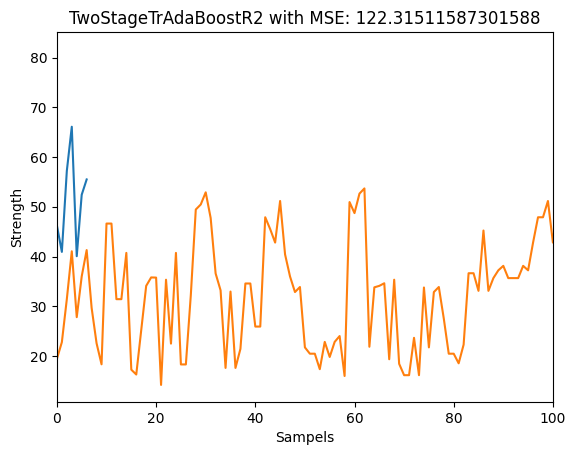

MSE Transfer Testdata:  122.31511587301588
MSE Transfer Validationdata:  253.63605569938875


In [135]:
from TL_Regression_Methods.TwoStageTrAdaBoostR2 import TwoStageTrAdaBoostR2
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

results_transfer = []
results_transfer_val = []

# Train Test Split
df_train, df_test= train_test_split(df_tar[:25], random_state=0)

# source
n_source1 = len(df_src)
x_source1 = df_src.iloc[:,:-1]
y_source1 = df_src.iloc[:,-1]

# target_train
n_target_train = len(df_train)
x_target_train = df_train.iloc[:,:-1]
y_target_train = df_train.iloc[:,-1]

# target_test
n_target_test = len(df_test)
x_target_test = df_test.iloc[:,:-1]
y_target_test = df_test.iloc[:,-1]

print(len(df_src),len(df_train),len(df_test))

for i in range(1, 2):
    # 4. transfer learning regressiong for the target_train data
    # 4.1 data combination and initial setting specification
    X = np.concatenate((x_source1, x_target_train))
    y = np.concatenate((y_source1, y_target_train))
    sample_size = [n_source1, n_target_train]

    n_estimators = 80
    steps = 10
    fold = 5
    random_state = np.random.RandomState(1)

    regr_1 = TwoStageTrAdaBoostR2(KNeighborsRegressor(n_neighbors=3),
                        n_estimators = n_estimators, sample_size = sample_size, 
                        steps = steps, fold = fold, 
                        random_state = random_state)
    regr_1.fit(X, y)
    y_pre_twostageboost = regr_1.predict(x_target_test)
    mse_twostageboost = mean_squared_error(y_target_test, y_pre_twostageboost) 

    results_transfer.append(mse_twostageboost)

    y_pre_twostageboost = regr_1.predict(Xt[25:])
    mse_ridge_val = sklearn.metrics.mean_squared_error(Yt[25:], y_pre_twostageboost)
    results_transfer_val.append(mse_ridge_val)

plt.plot(y_target_test.reset_index(drop=True))
plt.plot(y_pre_twostageboost)
plt.xlim(0, 100)
plt.title('TwoStageTrAdaBoostR2 with MSE: '+ str(mse_twostageboost))
plt.xlabel('Sampels')
plt.ylabel('Strength')
plt.show()

print("MSE Transfer Testdata: ", np.mean(results_transfer))
print("MSE Transfer Validationdata: ", np.mean(results_transfer_val))

# Baselines

## Baseline DecisionTreeRegressor

In [38]:
import sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

results_transfer = []
results_transfer_val = []

# Train Test Split
X_train, X_test, y_train, y_test= train_test_split(Xt[:25], Yt[:25], random_state=0)

for i in range(1, 200):
    clf = DecisionTreeRegressor(max_depth=5)
    clf.fit(X_train, y_train)
    y_pre_ridge = clf.predict(X_test)
    mse_ridge = sklearn.metrics.mean_squared_error(y_test, y_pre_ridge)
    results_transfer.append(mse_ridge)

    y_pre_ridge = clf.predict(Xt[25:])
    mse_ridge_val = sklearn.metrics.mean_squared_error(Yt[25:], y_pre_ridge)
    results_transfer_val.append(mse_ridge_val)

'''plt.plot(y_test.reset_index(drop=True))
plt.plot(y_pre_ridge)
plt.xlim(0, len(y_target_test))
plt.title('Decision Tree Regressor with MSE: '+ str(mse_ridge))
plt.xlabel('Sampels')
plt.ylabel('Strength')
plt.show()'''

print("MSE Baseline Testdata: ", np.mean(results_transfer))
print("MSE Baseline Validationdata: ", np.mean(results_transfer_val))

MSE Baseline Testdata:  8.766784170854269
MSE Baseline Validationdata:  230.44358653014268


## Baseline KNeighborsRegressor 

In [121]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

results_transfer = []
results_transfer_val = []

# Train Test Split
X_train, X_test, y_train, y_test= train_test_split(Xt[:25], Yt[:25], random_state=0)

for i in range(1, 200):
    clf = KNeighborsRegressor(n_neighbors=3)
    clf.fit(X_train, y_train)
    y_pre_ridge = clf.predict(X_test)
    mse_knr = sklearn.metrics.mean_squared_error(y_test, y_pre_ridge)

    results_transfer.append(mse_knr)

    y_pre_ridge = clf.predict(Xt[25:])
    mse_ridge_val = sklearn.metrics.mean_squared_error(Yt[25:], y_pre_ridge)
    results_transfer_val.append(mse_ridge_val)

'''plt.plot(y_test.reset_index(drop=True))
plt.plot(y_pre_ridge)
plt.xlim(0, len(y_test))
plt.title('KNeighborsRegressor: '+ str(mse_knr))
plt.xlabel('Sampels')
plt.ylabel('Strength')
plt.show()

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)'''

print("MSE Baseline Testdata: ", np.mean(results_transfer))
print("MSE Baseline Validationdata: ", np.mean(results_transfer_val))

MSE Baseline Testdata:  179.20678571428567
MSE Baseline Validationdata:  334.6286577849695


## Baseline SVR

In [72]:
from sklearn.svm import SVR

results_transfer = []
results_transfer_val = []

# Train Test Split
X_train, X_test, y_train, y_test= train_test_split(Xt[:25], Yt[:25], random_state=0)

for i in range(1, 200):
    clf = SVR(kernel="linear")
    clf.fit(X_train, y_train)
    y_pre_ridge = clf.predict(X_test)
    mse_knr = sklearn.metrics.mean_squared_error(y_test, y_pre_ridge)

    results_transfer.append(mse_knr)

    y_pre_ridge = clf.predict(Xt[25:])
    mse_ridge_val = sklearn.metrics.mean_squared_error(Yt[25:], y_pre_ridge)
    results_transfer_val.append(mse_ridge_val)

'''plt.plot(y_test.reset_index(drop=True))
plt.plot(y_pre_ridge)
plt.xlim(0, len(y_test))
plt.title('KNeighborsRegressor: '+ str(mse_knr))
plt.xlabel('Sampels')
plt.ylabel('Strength')
plt.show()

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)'''

print("MSE Baseline Testdata: ", np.mean(results_transfer))
print("MSE Baseline Validationdata: ", np.mean(results_transfer_val))


MSE Baseline Testdata:  1786.1158838418248
MSE Baseline Validationdata:  2286.4154369008415


## Baseline Lasso

In [70]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

results_transfer = []
results_transfer_val = []

# Train Test Split
X_train, X_test, y_train, y_test= train_test_split(Xt[:25], Yt[:25], random_state=0)

for i in range(1, 200):
    clf = linear_model.Lasso(alpha=15)
    clf.fit(X_train, y_train)
    y_pre_ridge = clf.predict(X_test)
    mse_ridge = sklearn.metrics.mean_squared_error(y_test, y_pre_ridge)
    results_transfer.append(mse_ridge)

    y_pre_ridge = clf.predict(Xt[25:])
    mse_ridge_val = sklearn.metrics.mean_squared_error(Yt[25:], y_pre_ridge)
    results_transfer_val.append(mse_ridge_val)

'''plt.plot(y_test.reset_index(drop=True))
plt.plot(y_pre_ridge)
plt.xlim(0, len(y_target_test))
plt.title('Decision Tree Regressor with MSE: '+ str(mse_ridge))
plt.xlabel('Sampels')
plt.ylabel('Strength')
plt.show()'''

print("MSE Baseline Testdata: ", np.mean(results_transfer))
print("MSE Baseline Validationdata: ", np.mean(results_transfer_val))

MSE Baseline Testdata:  57.24992342366318
MSE Baseline Validationdata:  127.90061788586358


## Baseline Ridge

In [71]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

results_transfer = []
results_transfer_val = []

# Train Test Split
X_train, X_test, y_train, y_test= train_test_split(Xt[:25], Yt[:25], random_state=0)

for i in range(1, 200):
    clf = Ridge(alpha=15)
    clf.fit(X_train, y_train)
    y_pre_ridge = clf.predict(X_test)
    mse_ridge = sklearn.metrics.mean_squared_error(y_test, y_pre_ridge)
    results_transfer.append(mse_ridge)

    y_pre_ridge = clf.predict(Xt[25:])
    mse_ridge_val = sklearn.metrics.mean_squared_error(Yt[25:], y_pre_ridge)
    results_transfer_val.append(mse_ridge_val)

'''plt.plot(y_test.reset_index(drop=True))
plt.plot(y_pre_ridge)
plt.xlim(0, len(y_target_test))
plt.title('Decision Tree Regressor with MSE: '+ str(mse_ridge))
plt.xlabel('Sampels')
plt.ylabel('Strength')
plt.show()'''

print("MSE Baseline Testdata: ", np.mean(results_transfer))
print("MSE Baseline Validationdata: ", np.mean(results_transfer_val))

MSE Baseline Testdata:  1894.5156570365539
MSE Baseline Validationdata:  2387.2123206185565


# Visulization

In [ ]:
#from TL_Regression_Methods.KMM import KMM
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

#BDA
bda = BDA(kernel_type='primal', dim=30, lamb=1, mu=0.5, mode='BDA', gamma=1, estimate_mu=False)
mse_bda, y_pre_bda, list_acc = bda.fit_predict(Xs, Ys, Xt, Yt)

#JDA
jda = JDA(kernel_type='primal', dim=30, lamb=1, gamma=1)
mse_jda, y_pre_jda, list_acc = jda.fit_predict(Xs, Ys, Xt, Yt)

#Coral
coral = CORAL()
k = 1
mse_coral, y_pre_coral = coral.fit_predict(Xs, Ys, Xt, Yt, k)

#KMM
model = KNeighborsRegressor(n_neighbors=7)
model.fit(Xs, Ys)
y_pre_kmm = model.predict(Xt)
mse_kmm = sklearn.metrics.mean_squared_error(Yt, ypre_kmm)

## Comparative Vis

In [ ]:
import sys
modname = globals()['__name__']
modobj  = sys.modules[modname]

metrics= ['bda', 'jda', 'coral', 'kmm','twostageboost','lwe']
colours= ['#1f77b4', '#2ca02c', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf','#1f77b4']
hor= [0,1,2,0,1,2]
ver= [0,1,0,1,0,1]

fig, axs = plt.subplots(2, 3)

c = 0
for i in metrics:
    axs[ver[c], hor[c]].plot(Yt.reset_index(drop=True), c='#1f77b4', label=i, linewidth=1)
    axs[ver[c], hor[c]].plot(getattr(modobj, "y_pre_"+ str(i)), c='#d62728', label=i, linewidth=1)
    axs[ver[c], hor[c]].set_title(i)
    axs[ver[c], hor[c]].set_xlim([0, 50])
    axs[ver[c], hor[c]].text(hor[c]*1.2+12, ver[c]*-1.2+2.15, 'MSE: '+ str(round(getattr(modobj, "mse_"+ str(i)),3)) )
    c+=1

fig.supxlabel('Sample')
fig.supylabel('Vorhersage')
fig.set_figwidth(10) 

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()